In [1]:
import pandas as pd

In [2]:

# This is the raw data our Spring Boot app will eventually send us.
# We are only interested in expenses for this analysis.
transactions = [
    {"description": "Rent Payment", "amount": 1200.00, "category": "Rent", "type": "EXPENSE"},
    {"description": "Starbucks Coffee", "amount": 5.75, "category": "Food", "type": "EXPENSE"},
    {"description": "Weekly Groceries", "amount": 85.50, "category": "Groceries", "type": "EXPENSE"},
    {"description": "Monthly Salary", "amount": 3000.00, "category": "Salary", "type": "INCOME"}, # This will be ignored
    {"description": "Train Ticket", "amount": 12.00, "category": "Transport", "type": "EXPENSE"},
    {"description": "Netflix Subscription", "amount": 15.99, "category": "Subscriptions", "type": "EXPENSE"},
    {"description": "Dinner with friends", "amount": 65.00, "category": "Food", "type": "EXPENSE"},
    {"description": "Car Insurance", "amount": 150.00, "category": "Utilities", "type": "EXPENSE"}
]

In [3]:
# The first thing we do is load this data into the pandas DataFrame.
# Think of a DataFrame as a super-powered spreadsheet inside python.

df = pd.DataFrame(transactions)

In [8]:
# Filter out anything that isn't an expense
df_expenses = df[df['type'] == 'EXPENSE'].copy()

In [11]:
print("----- Step 1: Our starting Expense Data ---")
print(df_expenses)

----- Step 1: Our starting Expense Data ---
            description   amount       category     type
0          Rent Payment  1200.00           Rent  EXPENSE
1      Starbucks Coffee     5.75           Food  EXPENSE
2      Weekly Groceries    85.50      Groceries  EXPENSE
4          Train Ticket    12.00      Transport  EXPENSE
5  Netflix Subscription    15.99  Subscriptions  EXPENSE
6   Dinner with friends    65.00           Food  EXPENSE
7         Car Insurance   150.00      Utilities  EXPENSE


In [23]:
"""
Translating to a Language the Computer Understands (Feature Engineering)
A computer doesn't understand "Food" or "Rent." It only understands numbers. 
We need to convert our data into a purely numerical format. The two pieces of information 
(the features) we care about are amount and category.
amount is already a number. Great!
category is text. We need to convert it. We'll use a technique called One-Hot Encoding.
One-Hot Encoding Analogy: Imagine for each transaction, you have a set of checkboxes: 
"Is this 'Food'?", "Is this 'Rent'?", "Is this 'Transport'?". You just check 'Yes' (1) 
or 'No' (0) for each one.
"""
# We start with the numerical 'amount' column
features = df_expenses[['amount']]


# Now we perform one-hot encoding on the 'category' column
# pd.get_dummies() automatically created the "checkbox" columns for us

category_dummies = pd.get_dummies(df_expenses['category'],prefix='category')


print("\n ---- Step 2a: The One-Hot Encoded Categories (Our CheckBoxes) ---")
print(category_dummies)


# Now, we combine our numerical amount with our new category checkboxes
# axis =1 tells pandas to join the side-by-side (as columns)
features = pd.concat([features, category_dummies], axis=1)

print("\n ---- Step 2b: Our Final Numerical Data for the Model ----")
print(features)




 ---- Step 2a: The One-Hot Encoded Categories (Our CheckBoxes) ---
   category_Food  category_Groceries  category_Rent  category_Subscriptions  \
0          False               False           True                   False   
1           True               False          False                   False   
2          False                True          False                   False   
4          False               False          False                   False   
5          False               False          False                    True   
6           True               False          False                   False   
7          False               False          False                   False   

   category_Transport  category_Utilities  
0               False               False  
1               False               False  
2               False               False  
4                True               False  
5               False               False  
6               False              

In [25]:
"""
Making it Fair (Feature Scaling)
Look at our numerical data. The amount for rent is 1200, while the value for category_Rent 
is just 1. The algorithm will mistakenly think the amount is 1200 times more important! 
We need to put all our numbers on the same scale. We'll use StandardScaler, which resizes 
everything to have an average of 0 and a standard deviation of 1.
"""

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform learns the scale and applies it in one step
scaled_features = scaler.fit_transform(features)

print("\n ----- Step 3: Our Data, Scaled and Ready for Clustering ----")
print(scaled_features)


 ----- Step 3: Our Data, Scaled and Ready for Clustering ----
[[ 2.43237626 -0.63245553 -0.40824829  2.44948974 -0.40824829 -0.40824829
  -0.40824829]
 [-0.52928529  1.58113883 -0.40824829 -0.40824829 -0.40824829 -0.40824829
  -0.40824829]
 [-0.33151053 -0.63245553  2.44948974 -0.40824829 -0.40824829 -0.40824829
  -0.40824829]
 [-0.5137857  -0.63245553 -0.40824829 -0.40824829 -0.40824829  2.44948974
  -0.40824829]
 [-0.50389077 -0.63245553 -0.40824829 -0.40824829  2.44948974 -0.40824829
  -0.40824829]
 [-0.38234919  1.58113883 -0.40824829 -0.40824829 -0.40824829 -0.40824829
  -0.40824829]
 [-0.17155477 -0.63245553 -0.40824829 -0.40824829 -0.40824829 -0.40824829
   2.44948974]]


In [26]:
from sklearn.cluster import KMeans

# We tell the algorithm we want to find 3 clusters (K = 3)
# random_state=42 ensures we get the same result every time we run the script. 
# It's like a lucky number for reproducibility.
# n_init='auto' is a modern setting to suppress a future warning.

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')

# fit_predict does the "assign, update, assign, update..." loop and gives us the final bin for each 
# Transaction.

cluster_labels = kmeans.fit_predict(scaled_features)

# Let's add these labels back to our original DataFrame to see the results
df_expenses['cluster'] = cluster_labels

print("\n ---- Step 4: Our Data with cluster labels Assigned ----")
print(df_expenses[['description','amount','category','cluster']])


 ---- Step 4: Our Data with cluster labels Assigned ----
            description   amount       category  cluster
0          Rent Payment  1200.00           Rent        2
1      Starbucks Coffee     5.75           Food        1
2      Weekly Groceries    85.50      Groceries        0
4          Train Ticket    12.00      Transport        1
5  Netflix Subscription    15.99  Subscriptions        1
6   Dinner with friends    65.00           Food        1
7         Car Insurance   150.00      Utilities        1


In [28]:
"""
The output now shows each transaction and the cluster (0, 1, or 2) it was assigned to.
 Translating Back to Human Language (Cluster Interpretation)
The computer gave us numbers 0, 1, 2. This is meaningless to a user. 
Our final job is to look inside each cluster and describe it in plain English.
"""

print("\n ---- Step 5: Interpreting the Clusters into Human-Readable Insights ----")

# We loop through each unique cluster ID (0, 1, 2)

for i in range(kmeans.n_clusters):
    print(f"\n-----------Analyzing Cluster {i} --------")

    # Get all transactions belonging to this cluster
    cluster_df = df_expenses[df_expenses['cluster'] == i]


    # Calculate some statistics to describe the cluster
    transaction_count = len(cluster_df)
    average_amount = cluster_df['amount'].mean()

    # .mode()[0] gets the most frequent category
    most_common_category = cluster_df['category'].mode()[0]

    # A  simple rule-based system to name our clusters
    cluster_name = "General Spending"
    if average_amount > 1000:
        cluster_name = "Major Bills & Payments"
    elif average_amount > 500:
        cluster_name = "Medium Bills & Payments"
    elif average_amount < 20:
        cluster_name = "Small, Daily Expenses"
    elif transaction_count > 2:
        cluster_name = "Regular Monthly Costs"


    print(f"Insight Name: '{cluster_name}'")
    print(f"    - Contains {transaction_count} transactions.")
    print(f"    - Average amount is ₹{average_amount:.2f}")
    print(f"    - The most common category is '{most_common_category}'")
    print("     - Transactions in this cluster:")
    print(cluster_df[['description','amount']])
    


 ---- Step 5: Interpreting the Clusters into Human-Readable Insights ----

-----------Analyzing Cluster 0 --------
Insight Name: 'General Spending'
    - Contains 1 transactions.
    - Average amount is ₹85.50
    - The most common category is 'Groceries'
     - Transactions in this cluster:
        description  amount
2  Weekly Groceries    85.5

-----------Analyzing Cluster 1 --------
Insight Name: 'Regular Monthly Costs'
    - Contains 5 transactions.
    - Average amount is ₹49.75
    - The most common category is 'Food'
     - Transactions in this cluster:
            description  amount
1      Starbucks Coffee    5.75
4          Train Ticket   12.00
5  Netflix Subscription   15.99
6   Dinner with friends   65.00
7         Car Insurance  150.00

-----------Analyzing Cluster 2 --------
Insight Name: 'Major Bills & Payments'
    - Contains 1 transactions.
    - Average amount is ₹1200.00
    - The most common category is 'Rent'
     - Transactions in this cluster:
    description  

In [29]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


------ Step 1: Finding the Optimal K with the Elbow Method -------
For K=1, Inertia = 49.0
For K=2, Inertia = 40.62733978311098
For K=3, Inertia = 25.570919160914134
For K=4, Inertia = 17.1636552907659
For K=5, Inertia = 8.72344693031647
For K=6, Inertia = 0.010795109898734665


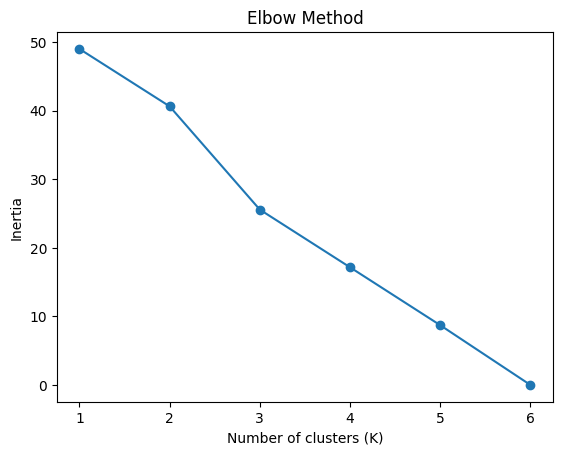

In [41]:
"""
The Problem with a "Fixed K"
In our last ML session, we told our K-Means algorithm exactly how many clusters to find:
Generated python
kmeans = KMeans(n_clusters=3, ...)
Use code with caution.
Python
We chose K=3 arbitrarily. But what if a user's spending habits are better described by 2 clusters (e.g., "Bills" and "Daily Spending")? 
Or maybe 4 clusters (e.g., "Major Bills," "Subscriptions," "Groceries," and "Fun Money")?
By hardcoding K=3, we might be forcing the data into groups that aren't natural. We are imposing our own bias on the model.
The Elbow Method is a popular technique to help us find the optimal number of clusters (K) for a specific dataset. 
It automates the process of choosing the best K.
Analogy: The "Tidying Up" Method
Imagine you have a messy room full of toys (your data points). You want to put them into storage bins (your clusters).
If you use only 1 bin (K=1): You just throw everything into one big bin. The room is "tidier," but the bin is a chaotic mess. 
The average distance from a toy to the center of the bin is very large. There's a lot of "error" or inertia.
If you use 2 bins (K=2): You might put all the LEGOs in one bin and all the stuffed animals in another. This is much better! 
The average distance from any toy to the center of its own bin is now much smaller. The inertia drops significantly.
If you use 3 bins (K=3): Maybe you separate LEGOs, stuffed animals, and toy cars. The groups are even tighter. 
The inertia drops again, but probably not as dramatically as the jump from 1 to 2.
If you use 10 bins for 10 toys (K=10): You put each toy in its own bin. The average distance from a toy to its bin's center is now zero! 
The inertia is zero. But is this useful? No. You haven't learned anything about the groups of toys.
The "Elbow" Insight: The most significant drop in "messiness" (inertia) happens when you find the natural number of groups.
Adding more bins after that point gives you diminishing returns.
We can plot this on a graph:
The X-axis is the number of clusters (K).
The Y-axis is the "messiness" or inertia.
The graph will look like a human arm. The point where it bends sharply—the "elbow"—is the sweet spot. 
It's the point where adding another cluster doesn't give you much benefit. That's our optimal K.
"""

from kneed import KneeLocator

print("------ Step 1: Finding the Optimal K with the Elbow Method -------")

# We will test a range of cluster numbers from 1 up to a max (e.g., 7)
# We can't have more clusters than data points.

max_k = min(7, len(df_expenses) - 1)
if max_k < 2:
    print("Not enough data points to form multiple clusters.")

    # Exit or handle this case appropriately
    exit()


inertia_scores = []
k_range = range(1, max_k + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_features)
    inertia_scores.append(kmeans.inertia_)
    print(f"For K={k}, Inertia = {kmeans.inertia_}")

# Can optionally plot this to see the elbow visually
import matplotlib.pyplot as plt
plt.plot(k_range, inertia_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [42]:
# The KneeLocator finds the "knee" or "elbow" of th curve.
# curve = 'convex' because the curve is convex (bulges outward).
# direction = 'decreasing' because inertia always decreases as K increases.
kl = KneeLocator(k_range, inertia_scores, curve='convex', direction='decreasing')
optimal_k = kl.elbow

# It's possible for kneed to not find a clear elbow, so we have a fallback.
if optimal_k is None:
    print("Could not automatically determine optimal K. Defaulting to 3. ")
    optimal_k = 3

print(f"\n -------- Step 2: The optimal number of clusters (K) is {optimal_k} --------")


Could not automatically determine optimal K. Defaulting to 3. 

 -------- Step 2: The optimal number of clusters (K) is 3 --------


In [ ]:
print(f"\n---- Step 3: Running final clustering with K={optimal_k} -------")


final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_expenses['cluster'] = final_kmeans.fit_predict(scaled_features)


# The interpretation logic from here is the same as before, but it's now more meaningful
# Because it's operating on the "correct" number of clusters.


# Remaining code can be written according to previous code.